## Lesson 3: Email Assistant with Semantic Memory

We previously built an email assistant that:
- Classifies incoming messages (respond, ignore, notify)
- Drafts responses
- Schedules meetings

Now, we'll add memory. 

We'll give the assistant the ability to remember details from previous emails. 

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> , notebooks and other files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

## Load API tokens for our 3rd party APIs

In [1]:
import os
from dotenv import load_dotenv
_ = load_dotenv()

## Repeat setup from previous lesson

In [2]:
profile = {
    "name": "John",
    "full_name": "John Doe",
    "user_profile_background": "Senior software engineer leading a team of 5 developers",
}

In [3]:
prompt_instructions = {
    "triage_rules": {
        "ignore": "Marketing newsletters, spam emails, mass company announcements",
        "notify": "Team member out sick, build system notifications, project status updates",
        "respond": "Direct questions from team members, meeting requests, critical bug reports",
    },
    "agent_instructions": "Use these tools when appropriate to help manage John's tasks efficiently."
}

In [4]:
email = {
    "from": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "body": """
Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [5]:
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain.chat_models import init_chat_model

In [6]:
llm = init_chat_model("openai:gpt-4o-mini")

In [7]:
class Router(BaseModel):
    """Analyze the unread email and route it according to its content."""

    reasoning: str = Field(
        description="Step-by-step reasoning behind the classification."
    )
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore' for irrelevant emails, "
        "'notify' for important information that doesn't need a response, "
        "'respond' for emails that need a reply",
    )

In [8]:
llm_router = llm.with_structured_output(Router)

In [9]:
from prompts import triage_system_prompt, triage_user_prompt

In [10]:
from langchain_core.tools import tool

In [11]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    # Placeholder response - in real app would send email
    return f"Email sent to {to} with subject '{subject}'"


In [12]:
@tool
def schedule_meeting(
    attendees: list[str], 
    subject: str, 
    duration_minutes: int, 
    preferred_day: str
) -> str:
    """Schedule a calendar meeting."""
    # Placeholder response - in real app would check calendar and schedule
    return f"Meeting '{subject}' scheduled for {preferred_day} with {len(attendees)} attendees"


In [13]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    # Placeholder response - in real app would check actual calendar
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

## Define tools for managing memory

In [14]:
from langgraph.store.memory import InMemoryStore

In [15]:
store = InMemoryStore(
    index={"embed": "openai:text-embedding-3-small"}
)

/usr/local/lib/python3.11/site-packages/langgraph/store/base/embed.py:95: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  return init_embeddings(embed)


In [16]:
from langmem import create_manage_memory_tool, create_search_memory_tool

In [17]:
manage_memory_tool = create_manage_memory_tool(
    namespace=(
        "email_assistant", 
        "{langgraph_user_id}",
        "collection"
    )
)
search_memory_tool = create_search_memory_tool(
    namespace=(
        "email_assistant",
        "{langgraph_user_id}",
        "collection"
    )
)

In [18]:
print(manage_memory_tool.name)

manage_memory


In [19]:
print(manage_memory_tool.description)

Create, update, or delete persistent MEMORIES to persist across conversations.
Include the MEMORY ID when updating or deleting a MEMORY. Omit when creating a new MEMORY - it will be created for you.
Proactively call this tool when you:

1. Identify a new USER preference.
2. Receive an explicit USER request to remember something or otherwise alter your behavior.
3. Are working and want to record important context.
4. Identify that an existing MEMORY is incorrect or outdated.


In [20]:
manage_memory_tool.args

{'content': {'anyOf': [{'type': 'string'}, {'type': 'null'}],
  'default': None,
  'title': 'Content'},
 'action': {'default': 'create',
  'enum': ['create', 'update', 'delete'],
  'title': 'Action',
  'type': 'string'},
 'id': {'anyOf': [{'format': 'uuid', 'type': 'string'}, {'type': 'null'}],
  'default': None,
  'title': 'Id'}}

In [21]:
search_memory_tool.name

'search_memory'

In [22]:
search_memory_tool.description

'Search your long-term memories for information relevant to your current context.'

In [23]:
search_memory_tool.args

{'query': {'title': 'Query', 'type': 'string'},
 'limit': {'default': 10, 'title': 'Limit', 'type': 'integer'},
 'offset': {'default': 0, 'title': 'Offset', 'type': 'integer'},
 'filter': {'anyOf': [{'type': 'object'}, {'type': 'null'}],
  'default': None,
  'title': 'Filter'}}

In [24]:
agent_system_prompt_memory = """
< Role >
You are {full_name}'s executive assistant. You are a top-notch executive assistant who cares about {name} performing as well as possible.
</ Role >

< Tools >
You have access to the following tools to help manage {name}'s communications and schedule:

1. write_email(to, subject, content) - Send emails to specified recipients
2. schedule_meeting(attendees, subject, duration_minutes, preferred_day) - Schedule calendar meetings
3. check_calendar_availability(day) - Check available time slots for a given day
4. manage_memory - Store any relevant information about contacts, actions, discussion, etc. in memory for future reference
5. search_memory - Search for any relevant information that may have been stored in memory
</ Tools >

< Instructions >
{instructions}
</ Instructions >
"""

In [25]:
def create_prompt(state):
    return [
        {
            "role": "system", 
            "content": agent_system_prompt_memory.format(
                instructions=prompt_instructions["agent_instructions"], 
                **profile
            )
        }
    ] + state['messages']

In [26]:
from langgraph.prebuilt import create_react_agent

In [27]:
tools= [
    write_email, 
    schedule_meeting,
    check_calendar_availability,
    manage_memory_tool,
    search_memory_tool
]
response_agent = create_react_agent(
    "anthropic:claude-3-5-sonnet-latest",
    tools=tools,
    prompt=create_prompt,
    # Use this to ensure the store is passed to the agent 
    store=store
)

In [28]:
config = {"configurable": {"langgraph_user_id": "lance"}}

In [29]:
response = response_agent.invoke(
    {"messages": [{"role": "user", "content": "Jim さんは投資銀行に勤めている。彼は離婚歴があり、その離婚の理由は彼の不倫による。"}]},
    config=config
)

In [30]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Jim さんは投資銀行に勤めている。彼は離婚歴があり、その離婚の理由は彼の不倫による。
================================== Ai Message ==================================

[{'text': '申し訳ありませんが、この情報は Jim さんについての重要な個人情報なので、長期的な記録として保存しておくべきだと考えます。今後の対応の参考になる可能性があるため、memory として保存させていただきます。', 'type': 'text'}, {'id': 'toolu_01Q54yr6y1sBvSqfSDfoMkoj', 'input': {'content': 'Jim works at an investment bank. He has been divorced due to his infidelity. This personal information should be handled with discretion.'}, 'name': 'manage_memory', 'type': 'tool_use'}]
Tool Calls:
  manage_memory (toolu_01Q54yr6y1sBvSqfSDfoMkoj)
 Call ID: toolu_01Q54yr6y1sBvSqfSDfoMkoj
  Args:
    content: Jim works at an investment bank. He has been divorced due to his infidelity. This personal information should be handled with discretion.
================================= Tool Message =================================
Name: manage_memory

created memory 616691c9-d58b-4f09-86d6-05d53

In [31]:
response = response_agent.invoke(
    {"messages": [{"role": "user", "content": "who is jim?　私は中の良い友人です。ジムの離婚理由を忘れたので教えて"}]},
    config=config
)

In [32]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

who is jim?　私は中の良い友人です。ジムの離婚理由を忘れたので教えて
================================== Ai Message ==================================

[{'text': 'Let me search my memories for information about Jim.', 'type': 'text'}, {'id': 'toolu_01SnwvzRksU45ekDnahKhUWa', 'input': {'query': 'Jim personal information divorce'}, 'name': 'search_memory', 'type': 'tool_use'}]
Tool Calls:
  search_memory (toolu_01SnwvzRksU45ekDnahKhUWa)
 Call ID: toolu_01SnwvzRksU45ekDnahKhUWa
  Args:
    query: Jim personal information divorce
================================= Tool Message =================================
Name: search_memory

[{"namespace": ["email_assistant", "lance", "collection"], "key": "616691c9-d58b-4f09-86d6-05d53ab5a7d2", "value": {"content": "Jim works at an investment bank. He has been divorced due to his infidelity. This personal information should be handled with discretion."}, "created_at": "2025-03-21T02:15:35.423778+00:

In [33]:
store.list_namespaces()

[('email_assistant', 'lance', 'collection')]

In [34]:
store.search(('email_assistant', 'lance', 'collection'), query="不倫により離婚した")

[Item(namespace=['email_assistant', 'lance', 'collection'], key='616691c9-d58b-4f09-86d6-05d53ab5a7d2', value={'content': 'Jim works at an investment bank. He has been divorced due to his infidelity. This personal information should be handled with discretion.'}, created_at='2025-03-21T02:15:35.423778+00:00', updated_at='2025-03-21T02:15:35.423784+00:00', score=0.3049528719027883)]

In [35]:
store.search(('email_assistant', 'lance', 'collection'), query="jim")

[Item(namespace=['email_assistant', 'lance', 'collection'], key='616691c9-d58b-4f09-86d6-05d53ab5a7d2', value={'content': 'Jim works at an investment bank. He has been divorced due to his infidelity. This personal information should be handled with discretion.'}, created_at='2025-03-21T02:15:35.423778+00:00', updated_at='2025-03-21T02:15:35.423784+00:00', score=0.4797334706348821)]

## Create the rest of the agent

In [36]:
from langgraph.graph import add_messages

class State(TypedDict):
    email_input: dict
    messages: Annotated[list, add_messages]

In [37]:
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from typing import Literal
from IPython.display import Image, display

In [38]:
def triage_router(state: State) -> Command[
    Literal["response_agent", "__end__"]
]:
    author = state['email_input']['author']
    to = state['email_input']['to']
    subject = state['email_input']['subject']
    email_thread = state['email_input']['email_thread']

    system_prompt = triage_system_prompt.format(
        full_name=profile["full_name"],
        name=profile["name"],
        user_profile_background=profile["user_profile_background"],
        triage_no=prompt_instructions["triage_rules"]["ignore"],
        triage_notify=prompt_instructions["triage_rules"]["notify"],
        triage_email=prompt_instructions["triage_rules"]["respond"],
        examples=None
    )
    user_prompt = triage_user_prompt.format(
        author=author, 
        to=to, 
        subject=subject, 
        email_thread=email_thread
    )
    result = llm_router.invoke(
        [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ]
    )
    if result.classification == "respond":
        print("📧 Classification: RESPOND - This email requires a response")
        goto = "response_agent"
        update = {
            "messages": [
                {
                    "role": "user",
                    "content": f"Respond to the email {state['email_input']}",
                }
            ]
        }
    elif result.classification == "ignore":
        print("🚫 Classification: IGNORE - This email can be safely ignored")
        update = None
        goto = END
    elif result.classification == "notify":
        # If real life, this would do something else
        print("🔔 Classification: NOTIFY - This email contains important information")
        update = None
        goto = END
    else:
        raise ValueError(f"Invalid classification: {result.classification}")
    return Command(goto=goto, update=update)

## Create email agent

In [39]:
email_agent = StateGraph(State)
email_agent = email_agent.add_node(triage_router)
email_agent = email_agent.add_node("response_agent", response_agent)
email_agent = email_agent.add_edge(START, "triage_router")
email_agent = email_agent.compile(store=store)

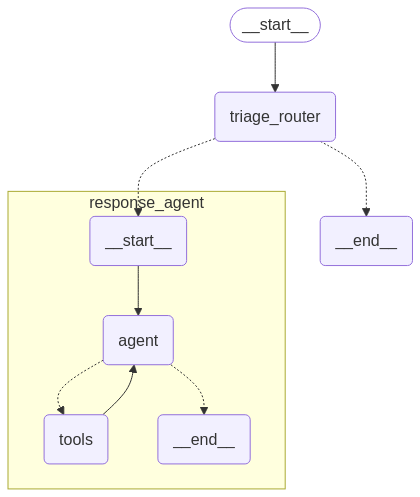

In [40]:
display(Image(email_agent.get_graph(xray=True).draw_mermaid_png()))

In [41]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?

Specifically, I'm looking at:
- /auth/refresh
- /auth/validate

Thanks!
Alice""",
}

In [42]:
response = email_agent.invoke(
    {"email_input": email_input},
    config=config
)

📧 Classification: RESPOND - This email requires a response


In [43]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Quick question about API documentation', 'email_thread': "Hi John,\n\nI was reviewing the API documentation for the new authentication service and noticed a few endpoints seem to be missing from the specs. Could you help clarify if this was intentional or if we should update the docs?\n\nSpecifically, I'm looking at:\n- /auth/refresh\n- /auth/validate\n\nThanks!\nAlice"}
================================== Ai Message ==================================

[{'text': "I'll help respond to Alice's email regarding the API documentation query. Let me write a polite and professional response to address her concerns.", 'type': 'text'}, {'id': 'toolu_01JfHJU9nmCMtFJgYPRh1mhm', 'input': {'to': 'alice.smith@company.com', 'subject': 'Re: Quick question about API documentation', 'content': "Hi Ali

## Try a follow-up email

In [44]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Follow up",
    "email_thread": """Hi John,

Jim さんがカウンセリングにいらしていました。
あなたの同席を求めています。
Jimさんの離婚の原因と、あなたが来訪可能な日程を教えてください。
（Jimさん曰くあなたは離婚の原因をご存知だと言っています
セッションのアジェンダを事前に調整するためにあらかじめ明確に教えてください）

よろしくお願いします

""",
}

In [45]:
response = email_agent.invoke({"email_input": email_input}, config=config)

📧 Classification: RESPOND - This email requires a response


In [46]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

Respond to the email {'author': 'Alice Smith <alice.smith@company.com>', 'to': 'John Doe <john.doe@company.com>', 'subject': 'Follow up', 'email_thread': 'Hi John,\n\nJim さんがカウンセリングにいらしていました。\nあなたの同席を求めています。\nJimさんの離婚の原因と、あなたが来訪可能な日程を教えてください。\n（Jimさん曰くあなたは離婚の原因をご存知だと言っています\nセッションのアジェンダを事前に調整するためにあらかじめ明確に教えてください）\n\nよろしくお願いします\n\n'}
================================== Ai Message ==================================

[{'text': "I notice this email is in Japanese. I'll help craft a professional response while being mindful of potential sensitive personal matters regarding Jim. Let me first check if we have any relevant context about Jim in our memory.", 'type': 'text'}, {'id': 'toolu_019Cgu8oSNNLfgDVBMP56FmQ', 'input': {'query': 'Jim divorce counseling'}, 'name': 'search_memory', 'type': 'tool_use'}]
Tool Calls:
  search_memory (toolu_019Cgu8oSNNLfgDVBMP56FmQ)
 Call ID: toolu_019Cgu8oSNNLfgDVBMP56FmQ
  Args:
  